In [14]:
# ===============================
# 1. Install and Imports
# ===============================
# !pip install torchvision timm torch tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import timm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [24]:
# ===============================
# 2. CIFAR-10 Dataset (Dual Transforms)
# ===============================

# ResNet expects 32×32
train_transform_resnet = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

test_transform_resnet = T.Compose([
    T.ToTensor()
])

# ViT expects 224×224
train_transform_vit = T.Compose([
    T.Resize(224),
    T.RandomCrop(224, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

test_transform_vit = T.Compose([
    T.Resize(224),
    T.ToTensor()
])

# Load datasets separately
trainset_resnet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_resnet)
testset_resnet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform_resnet)
trainloader_resnet = DataLoader(trainset_resnet, batch_size=64, shuffle=True, num_workers=2)
testloader_resnet = DataLoader(testset_resnet, batch_size=64, shuffle=False, num_workers=2)

trainset_vit = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_vit)
testset_vit = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform_vit)
trainloader_vit = DataLoader(trainset_vit, batch_size=64, shuffle=True, num_workers=2)
testloader_vit = DataLoader(testset_vit, batch_size=64, shuffle=False, num_workers=2)


In [16]:
# ===============================
# 3. Load Models: ResNet18 and ViT-tiny
# ===============================

# ResNet18 from scratch (no pretrained weights)
resnet = torchvision.models.resnet18(weights=None, num_classes=10).to(device)

# ViT-tiny (DeiT-tiny, pretrained on ImageNet)
vit = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=10).to(device)

In [17]:
# ===============================
# 4. Training Function
# ===============================

def train_model(model, trainloader, testloader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)

        # evaluation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = 100 * correct / total
        test_accuracies.append(acc)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")

    return train_losses, test_accuracies


In [18]:
# ===============================
# 5. Train Both Models
# ===============================

print("\nTraining ResNet18...")
resnet_losses, resnet_accs = train_model(resnet, trainloader_resnet, testloader_resnet, epochs=10)

print("\nTraining ViT-tiny...")
vit_losses, vit_accs = train_model(vit, trainloader_vit, testloader_vit, epochs=10)


Training ResNet18...


Epoch 1/10 | Train Loss: 1.5582 | Test Acc: 54.79%


Epoch 2/10 | Train Loss: 1.1941 | Test Acc: 47.80%


Epoch 3/10 | Train Loss: 1.0347 | Test Acc: 59.64%


Epoch 4/10 | Train Loss: 0.9313 | Test Acc: 69.94%


Epoch 5/10 | Train Loss: 0.8551 | Test Acc: 66.54%


Epoch 6/10 | Train Loss: 0.7936 | Test Acc: 70.83%


Epoch 7/10 | Train Loss: 0.7485 | Test Acc: 68.54%


Epoch 8/10 | Train Loss: 0.7041 | Test Acc: 73.78%


Epoch 9/10 | Train Loss: 0.6737 | Test Acc: 71.31%


Epoch 10/10 | Train Loss: 0.6467 | Test Acc: 73.39%

Training ViT-tiny...


Epoch 1/10 | Train Loss: 1.7196 | Test Acc: 50.10%


Epoch 2/10 | Train Loss: 1.1943 | Test Acc: 60.51%


Epoch 3/10 | Train Loss: 1.0019 | Test Acc: 67.11%


Epoch 4/10 | Train Loss: 0.8740 | Test Acc: 69.32%


Epoch 5/10 | Train Loss: 0.7793 | Test Acc: 72.61%


Epoch 6/10 | Train Loss: 0.7086 | Test Acc: 74.34%


Epoch 7/10 | Train Loss: 0.6456 | Test Acc: 75.44%


Epoch 8/10 | Train Loss: 0.5921 | Test Acc: 76.36%


Epoch 9/10 | Train Loss: 0.5482 | Test Acc: 77.46%


Epoch 10/10 | Train Loss: 0.5048 | Test Acc: 77.88%


In [ ]:
# ===============================
# 6. Plotting Results
# ===============================

plt.figure(figsize=(8,5))
plt.plot(resnet_accs, label="ResNet18 Test Acc")
plt.plot(vit_accs, label="ViT-tiny Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.title("Training Progress")
plt.show()


In [ ]:
# ===============================
# 7. Attack Implementations
# ===============================

def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    adv_images = images + epsilon * images.grad.sign()
    adv_images = torch.clamp(adv_images, 0, 1).detach()
    return adv_images

def bim_attack(model, images, labels, epsilon, alpha=0.01, iters=5):
    adv_images = images.clone().detach()
    adv_images.requires_grad = True

    for _ in range(iters):
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = adv_images + alpha * adv_images.grad.sign()
        adv_images = torch.clamp(adv_images, 0, 1).detach()
        adv_images.requires_grad_(True)
    return adv_images

def pgd_attack(model, images, labels, epsilon, alpha=0.01, iters=5):
    ori_images = images.clone().detach()
    adv_images = ori_images.clone().detach()
    adv_images.requires_grad = True

    for _ in range(iters):
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        adv_images = adv_images + alpha * adv_images.grad.sign()
        perturbation = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(ori_images + perturbation, 0, 1).detach()
        adv_images.requires_grad_(True)
    return adv_images


In [ ]:
# ===============================
# 8. Evaluate Models Under Attack
# ===============================

def evaluate_attack(model, loader, attack_fn=None, epsilon=0.0):
    model.eval()
    correct = 0
    total = 0
    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)
        if attack_fn is None:
            with torch.no_grad():
                outputs = model(images)
        else:
            adv_images = attack_fn(model, images, labels, epsilon)
            outputs = model(adv_images)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return 100 * correct / total


In [27]:
# ===============================
# 9. Run All Experiments
# ===============================

epsilons = [0.0, 0.01, 0.03, 0.05]

# Store results
resnet_results = {"FGSM":[], "BIM":[], "PGD":[]}
vit_results = {"FGSM":[], "BIM":[], "PGD":[]}

for eps in epsilons:
    print(f"\n=== Epsilon = {eps:.2f} ===")

    # ResNet18
    acc = evaluate_attack(resnet, testloader_resnet, fgsm_attack if eps>0 else None, eps)
    resnet_results["FGSM"].append(acc)
    print(f"ResNet18 FGSM Accuracy: {acc:.2f}%")

    acc = evaluate_attack(resnet, testloader_resnet, bim_attack if eps>0 else None, eps)
    resnet_results["BIM"].append(acc)
    print(f"ResNet18 BIM Accuracy: {acc:.2f}%")

    acc = evaluate_attack(resnet, testloader_resnet, pgd_attack if eps>0 else None, eps)
    resnet_results["PGD"].append(acc)
    print(f"ResNet18 PGD Accuracy: {acc:.2f}%")

    # ViT-tiny
    acc = evaluate_attack(vit, testloader_vit, fgsm_attack if eps>0 else None, eps)
    vit_results["FGSM"].append(acc)
    print(f"ViT-tiny FGSM Accuracy: {acc:.2f}%")

    acc = evaluate_attack(vit, testloader_vit, bim_attack if eps>0 else None, eps)
    vit_results["BIM"].append(acc)
    print(f"ViT-tiny BIM Accuracy: {acc:.2f}%")

    acc = evaluate_attack(vit, testloader_vit, pgd_attack if eps>0 else None, eps)
    vit_results["PGD"].append(acc)
    print(f"ViT-tiny PGD Accuracy: {acc:.2f}%")



=== Epsilon = 0.00 ===


ResNet18 FGSM Accuracy: 73.39%


ResNet18 BIM Accuracy: 73.39%


ResNet18 PGD Accuracy: 73.39%


ViT-tiny FGSM Accuracy: 77.88%


ViT-tiny BIM Accuracy: 77.88%


ViT-tiny PGD Accuracy: 77.88%

=== Epsilon = 0.01 ===


ResNet18 FGSM Accuracy: 29.53%


ResNet18 BIM Accuracy: 0.03%


ResNet18 PGD Accuracy: 22.64%


ViT-tiny FGSM Accuracy: 7.62%


ViT-tiny BIM Accuracy: 0.00%


ViT-tiny PGD Accuracy: 2.03%

=== Epsilon = 0.03 ===


ResNet18 FGSM Accuracy: 4.36%


ResNet18 BIM Accuracy: 0.03%


ResNet18 PGD Accuracy: 0.59%


ViT-tiny FGSM Accuracy: 0.83%


ViT-tiny BIM Accuracy: 0.00%


ViT-tiny PGD Accuracy: 0.00%

=== Epsilon = 0.05 ===


ResNet18 FGSM Accuracy: 1.59%


ResNet18 BIM Accuracy: 0.03%


ResNet18 PGD Accuracy: 0.03%


ViT-tiny FGSM Accuracy: 1.85%


ViT-tiny BIM Accuracy: 0.00%


ViT-tiny PGD Accuracy: 0.00%


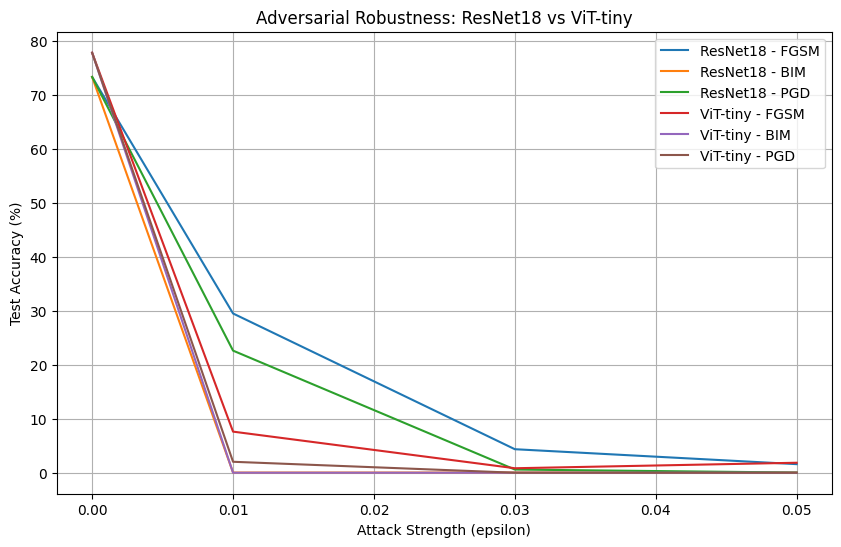

In [28]:
# ===============================
# 10. Plot Results
# ===============================

plt.figure(figsize=(10,6))

plt.plot(epsilons, resnet_results["FGSM"], label="ResNet18 - FGSM")
plt.plot(epsilons, resnet_results["BIM"], label="ResNet18 - BIM")
plt.plot(epsilons, resnet_results["PGD"], label="ResNet18 - PGD")

plt.plot(epsilons, vit_results["FGSM"], label="ViT-tiny - FGSM")
plt.plot(epsilons, vit_results["BIM"], label="ViT-tiny - BIM")
plt.plot(epsilons, vit_results["PGD"], label="ViT-tiny - PGD")

plt.xlabel("Attack Strength (epsilon)")
plt.ylabel("Test Accuracy (%)")
plt.title("Adversarial Robustness: ResNet18 vs ViT-tiny")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# ===============================
# 11. Print Table of Results
# ===============================

print("\n| Epsilon | Model | FGSM Acc | BIM Acc | PGD Acc |")
print("|:-------:|:-----:|:--------:|:-------:|:-------:|")

for i, eps in enumerate(epsilons):
    print(f"| {eps:.2f} | ResNet18 | {resnet_results['FGSM'][i]:.2f}% | {resnet_results['BIM'][i]:.2f}% | {resnet_results['PGD'][i]:.2f}% |")
    print(f"| {eps:.2f} | ViT-tiny | {vit_results['FGSM'][i]:.2f}% | {vit_results['BIM'][i]:.2f}% | {vit_results['PGD'][i]:.2f}% |")



| Epsilon | Model | FGSM Acc | BIM Acc | PGD Acc |
|:-------:|:-----:|:--------:|:-------:|:-------:|
| 0.00 | ResNet18 | 73.39% | 73.39% | 73.39% |
| 0.00 | ViT-tiny | 77.88% | 77.88% | 77.88% |
| 0.01 | ResNet18 | 29.53% | 0.03% | 22.64% |
| 0.01 | ViT-tiny | 7.62% | 0.00% | 2.03% |
| 0.03 | ResNet18 | 4.36% | 0.03% | 0.59% |
| 0.03 | ViT-tiny | 0.83% | 0.00% | 0.00% |
| 0.05 | ResNet18 | 1.59% | 0.03% | 0.03% |
| 0.05 | ViT-tiny | 1.85% | 0.00% | 0.00% |
